In [266]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sb
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE

In [267]:
df = pd.read_csv("D:\PROGRAMMING\DATASETS\health care diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [268]:
print(df['Outcome'].value_counts())    ## no. of vals
print()
print(df['Outcome'].value_counts('0')) ## % of vals

## Hence, Our data is imbalanced

Outcome
0    500
1    268
Name: count, dtype: int64

Outcome
0    0.651042
1    0.348958
Name: proportion, dtype: float64


In [269]:
## Independent / Dependent Variables Split
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [270]:
## Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)
cols = X_train.columns

<h2>SMOTE</h2>

In [271]:
os = SMOTE(random_state=0)
os_data_X, os_data_y = os.fit_resample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X, columns=cols)
os_data_y = pd.DataFrame(data=os_data_y, columns=['Outcome'])

In [272]:
print(os_data_y.value_counts())

## Now our data is balanced

Outcome
0          343
1          343
Name: count, dtype: int64


In [273]:
X = os_data_X
y = os_data_y

In [274]:
est = sm.Logit(y, X).fit()
print(est.summary())

Optimization terminated successfully.
         Current function value: 0.628161
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                Outcome   No. Observations:                  686
Model:                          Logit   Df Residuals:                      678
Method:                           MLE   Df Model:                            7
Date:                Sun, 30 Jul 2023   Pseudo R-squ.:                 0.09376
Time:                        16:16:46   Log-Likelihood:                -430.92
converged:                       True   LL-Null:                       -475.50
Covariance Type:            nonrobust   LLR p-value:                 1.839e-16
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Pregnancies                  0.0919      0.029      3.187      0.001       0.035

In [275]:
## Variance Inflatin Factor (VIF)
def find_vif(xv):
    vif = pd.DataFrame()
    vif['variables'] = xv.columns
    vif['vif'] = [variance_inflation_factor(xv.values, k) for k in range(xv.shape[1])]
    return vif

In [276]:
X = X.drop(['SkinThickness', 'Age'], axis = 1)
xv = X
find_vif(xv)
# X.columns

,variables,vif
0,Pregnancies,2.497701
1,Glucose,15.431671
2,BloodPressure,13.711670
3,Insulin,1.731119
4,BMI,18.280255
5,DiabetesPedigreeFunction,3.224386


In [277]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

In [278]:
## Standard Scalling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

In [279]:
## Model Training
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_predict = logreg.predict(X_test)

In [280]:
final = pd.DataFrame(np.c_[y_test, y_predict], columns = ["Actual", "Predicted"])

In [281]:
print("Accuracy Score for train is : ", end="")
print((logreg.score(X_train, y_train)).__round__(4)*100)
print("Accuracy Score for test is : ", end="")
print((logreg.score(X_test, y_test)).__round__(4)*100)

Accuracy Score for train is : 75.83
Accuracy Score for test is : 75.73


In [282]:
## Confusion Matrix
cm = metrics.confusion_matrix(y_test, y_predict)
print(cm)

[[81 21]
 [29 75]]


In [283]:
print(metrics.classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.74      0.79      0.76       102
           1       0.78      0.72      0.75       104

    accuracy                           0.76       206
   macro avg       0.76      0.76      0.76       206
weighted avg       0.76      0.76      0.76       206



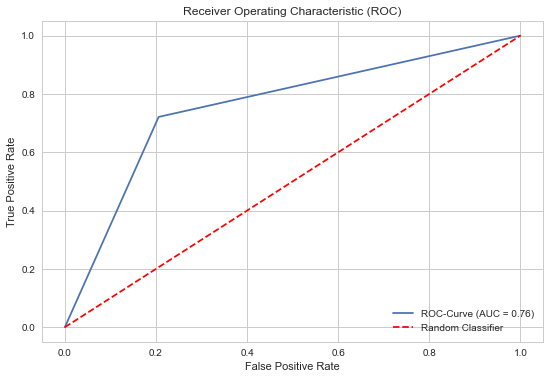

In [284]:
plt.style.use('seaborn-whitegrid')
y_predict_prob = logreg.predict_proba(X_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_predict)
auc = metrics.roc_auc_score(y_test, y_predict)

plt.plot(fpr, tpr, label = "ROC-Curve (AUC = %0.2f)"%auc)
plt.plot([0, 1], [0, 1], 'r--', label = "Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC)")
plt.legend(loc = "lower right")
plt.show()